In [1]:
from datasets.coco_dataset import CocoDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensor


In [2]:
transforms = A.Compose([
    A.Normalize(),
    ToTensor()
])

In [3]:
dataset = CocoDataset(
    root_dir = 'datasets/vinai512/images/train',
    ann_path = 'datasets/vinai512/annotations/vinai512_train.json',
    transforms = transforms
)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


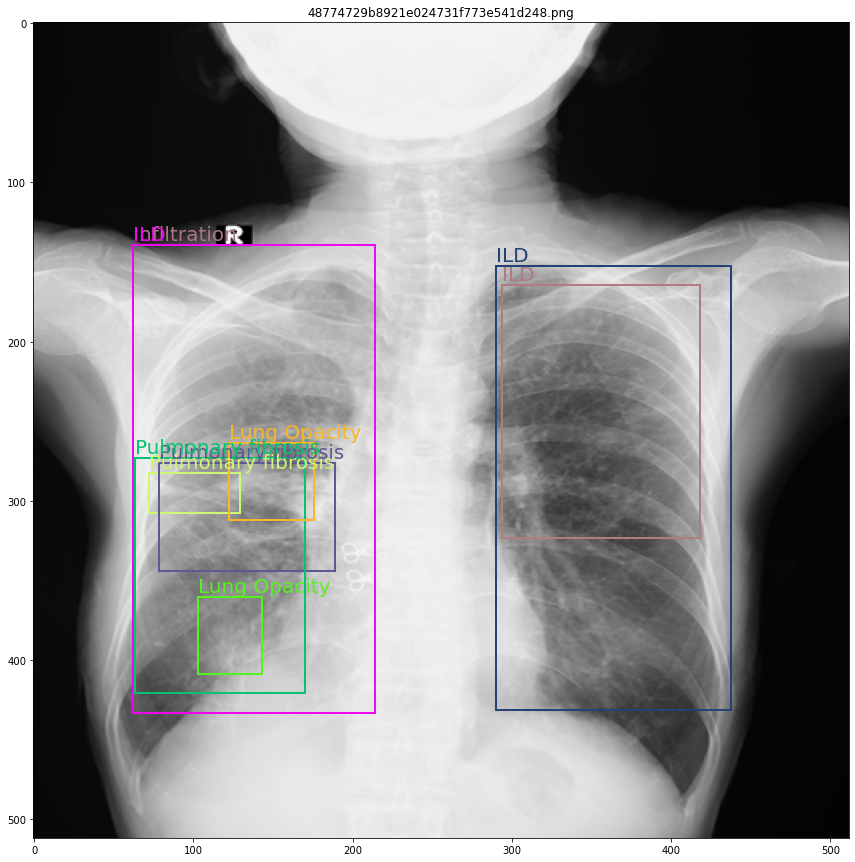

In [14]:
dataset.visualize_item(15)

In [ ]:
trainset = CocoDataset(
    root_dir = 'datasets/vinai1024/train',
    ann_path = 'datasets/coco_vinai_train1024.json',
    transforms = transforms
)

valset = CocoDataset(
    root_dir = 'datasets/vinai1024/val',
    ann_path = 'datasets/coco_vinai_val1024.json',
    transforms = transforms
)

In [ ]:
print(dataset.labels)

In [ ]:
%matplotlib inline
dataset.visualize_item(figsize=(10,10))

In [ ]:
trainset.coco.anns

In [ ]:
trainset.plot(types=['object_freqs'], figsize=(20,20))

In [ ]:
valset.plot(types=['freqs'], figsize=(20,20))